In [27]:
import statsmodels.api as sm
import numpy as np
from scipy.optimize import minimize
from tabulate import tabulate
from numpy import linalg as la
import time
import pandas as pd
import mestim as M
from discrete_choice import * 
import matplotlib.pyplot as plt

from numpy import random
from scipy.stats import genextreme


## Hjælpefunktioner

In [7]:
def estimation(Qfun, theta0, deriv=0, cov_type ='sandwich', parnames='', output=False):

    tic = time.perf_counter()

    # Q: Sample objective function to minimize (e.g. sample average of negative log-livelihood)
    Q     = lambda theta:  Qfun(theta, out='Q')

    # dQ: Derivative of sample objective function wrt parameters theta (function returns size K array)
    dQ = None
    if deriv>0: # use user-supplied 1 order derivatives
        dQ = lambda theta:  Qfun(theta, out='dQ')

    hess = None
    if deriv>1: # use user-supplied 2 order derivatives
        hess  =  lambda theta:  Qfun(theta, out='H')
        res=minimize(fun=Q, jac=dQ, hess=hess, x0=theta0, method='trust-ncg')
        res.hess_inv=la.inv(res.hess)
    else: # use bfgs
        res=minimize(fun=Q, jac=dQ, x0=theta0, method='bfgs')

    theta_hat=np.array(res.x).reshape(-1,1)

    toc = time.perf_counter()

    # variance co-variance matrix
    s_i=Qfun(theta_hat, out='s_i')

    cov = avar(s_i, res.hess_inv, cov_type)
    se = np.sqrt(np.diag(cov)).reshape(-1, 1)

    # collect output
    names =   ['parnames', 'theta_hat', 'se',  't-values',  'cov', 'Q', 'time', 's_i']
    results = [parnames, theta_hat, se, theta_hat/se, cov, Q(theta_hat), toc - tic, s_i]

    res.update(dict(zip(names, results)))

    if output:
        if res.parnames:
            table=({k:res[k] for k in ['parnames', 'theta_hat', 'se', 't-values', 'jac']})
        else:
            table=({k:res[k] for k in ['theta_hat', 'se', 't-values', 'jac']})
        print(tabulate(table, headers="keys",floatfmt="10.5f"))
        print('')
        print(res.message)
        print('Objective function:', res['Q'])
        print ('Iteration info: %d iterations, %d evaluations of objective, and %d evaluations of gradients'
            % (res.nit,res.nfev, res.njev))
        print(f"Elapsed time: {res['time']:0.4f} seconds")

    return res

def avar(s_i, Ainv, cov_type ='sandwich'):
    n, K=s_i.shape
    B=s_i.T@ s_i/n
    if cov_type=='Ainv':        return Ainv/n;
    if cov_type=='Binv':        return la.inv(B)/n
    if cov_type=='sandwich':    return Ainv @ B @ Ainv/n

In [8]:
def sim_data(N, J, theta) -> tuple:
    k = theta.size

    x = random.normal(size=(N, J, k)) + np.linspace(3,5,J).reshape(1,J, 1)
    v = utiliy(theta, x)
    e = genextreme.ppf(random.uniform(size=(N, J)), c=0)
    u = v + e # utility

    # Find which choice that maximizes utility.
    y = u.argmax(axis=1)

    label = ['y', 'x']
    d=dict(zip(label, [y, x]))
    return d

def clogit(y, x, cov_type='Ainv',theta0=None, deriv=0, quiet=False):
	# Objective function and derivatives for
    N, J, K, palt, xalt, xvars = labels(x)
    Qfun     = lambda theta, out:  Q_clogit(theta, y, x, out)

    if theta0 is None:
    	theta0=np.zeros((K,1))

    res = estimation(Qfun, theta0, deriv, cov_type, parnames=xvars)
    # v, p, dv = Qfun(res.theta_hat, out='predict')
    res.update(dict(zip(['yvar', 'xvars', 'N','K', 'n'], ['y', xvars, N, K, N])))

    if quiet==False:
        print('Conditional logit')
        print('Initial log-likelihood', -Qfun(theta0, 'Q'))
        print('Initial gradient\n', -Qfun(theta0, 'dQ'))
        print_output(res)

    return res

def Q_clogit(theta, y, x, out='Q'):
    v = utiliy(theta, x) 	# Deterministic component of utility
    ll_i=logccp(v, y)
    q_i= - ll_i
    dv = x
    p=ccp(v)
    if out=='Q':
    	return np.mean(q_i)
    if out=='predict':  return v, p, dv         # Return predicted values
    N, J, K = dv.shape
    idx=y[:,] + J*np.arange(0, N)
    dvj=dv.reshape(N*J, K)[idx,:] 	# pick choice specific values corresponding to y

    s_i=dvj -  np.sum(p.reshape(N,J,1)*dv, axis=1)
    g=-np.mean(s_i, axis=0)

    if out=='s_i': return s_i                     # Return s_i: NxK array with scores
    if out=='dQ':  return g;  # Return dQ: array of size K derivative of sample objective function

def utiliy(theta, x):
	N, J, K=x.shape
	u = x @ theta
	return u.reshape(N,J)

def logsum(v, sigma=1):
	# Expected max over iid extreme value shocks with scale parameter sigma
	# Logsum is reentered around maximum to obtain numerical stability (avoids overflow, but accepts underflow)
	max_v = v.max(axis=1).reshape(-1, 1)
	return max_v + sigma*np.log(np.sum(np.exp((v-max_v)/sigma), 1)).reshape(-1, 1)

def logccp(v, y=None, sigma=1):
    # Log of conditional choice probabilities
    # If y=None return logccp corresponding to all choices
    # if y is Nx1 vector of choice indexes, return likelihood

    ev=logsum(v, sigma) 	# Expected utility (always larger than V)
    if y is not None:
    	N, J=v.shape
    	idx = y[:,] + J*np.arange(0, N)
    	v = v.reshape(N*J, 1)[idx] 	# pick choice specific values corresponding to y
    return (v - ev)/sigma

def ccp(v, y=None, sigma=1):     # Conditional choice probabilities
    return np.exp(logccp(v, y, sigma))

def labels(x):
	# labels and dimensions for plotting
	N, J, K = x.shape
	palt=['p' + str(i)  for i in range(J)];
	xalt=['alt' + str(i)  for i in range(J)];
	xvars=['var' + str(i)  for i in range(K)];
	return N, J, K, palt, xalt, xvars

def APE_var(theta, x, m=0, quiet=False):
	# matrix of partial derivatives with respect of a change in attribute m
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E=np.empty((J,J))
    for j in range(J):
        for k in range(J):
            E[k, j]=np.mean(p[:,j]*theta[m]*(1*(j==k)-p[:,k]), axis=0)
    if not quiet:
        print('\nAPE wrt change in', xvars[m])
        print(tabulate(np.c_[xalt, E], headers=palt,floatfmt="10.5f"))
    return E

def Ematrix_var(theta, x, m=0, quiet=False):
	# matrix of elasticities with respect ot a change in attribute m
	N, J, K, palt, xalt, xvars = labels(x)
	p=ccp(utiliy(theta, x))
	E=np.empty((J,J))
	for j in range(J):
	    for k in range(J):
	        E[k, j]=np.mean(x[:,k,m]*theta[m]*(1*(j==k)-p[:,k]), axis=0)
	if not quiet:
	    print('\nElasticity wrt change in', xvars[m])
	    print(tabulate(np.c_[xalt, E], headers=palt,floatfmt="10.5f"))
	return E

def Ematrix_own(theta, x, quiet=False):
    # Own elasticity: % change in prob of alternative j wrt % change in attribute of same alternative j
    # done for for each variable in x
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E_own=np.empty((J, K))
    for iJ in range(J):
        for iK in range(K):
            E_own[iJ, iK]=np.mean(x[:,iJ,iK]*theta[iK]*(1-p[:,iJ]), axis=0)
    if not quiet:
        print('\nOwn elasticity')
        print(tabulate(np.c_[xalt, E_own], headers=xvars,floatfmt="10.5f"))
    return E_own

def Ematrix_cross(theta, x, quiet=False):
    # Cross elasticity:  % change in prob of alternative j wrt % change in attribute of other alternative k ne j
    # done for each variable in x
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E_cross=np.empty((J, K))
    for iJ in range(J):
        for iK in range(K):
            E_cross[iJ, iK]=np.mean(x[:,iJ,iK]*theta[iK]*(-p[:,iJ]), axis=0)
    if not quiet:
        print('\nCross-Elasticity')
        print(tabulate(np.c_[xalt, E_cross], headers=xvars,floatfmt="10.5f"))

def print_output(res, cols=['parnames','theta_hat', 'se', 't-values', 'jac']):
    print('Dep. var. :', res['yvar'], '\n')

    table=({k:res[k] for k in cols})
    print(tabulate(table, headers="keys",floatfmt="10.5f"))
    # print('\n# of groups:      :', res['n'])
    print('# of observations :', res['N'])
    print('# log-likelihood. :', - res['Q']*res['n'], '\n')
    print ('Iteration info: %d iterations, %d evaluations of objective, and %d evaluations of gradients'
        % (res.nit,res.nfev, res.njev))
    print(f"Elapsed time: {res['time']:0.4f} seconds")
    print('')

## Data

In [18]:
df1 = pd.read_csv('Overview.csv')
df1.sample(5)

,ID,Manufacturer,Model,Range,Price,HP,Fast charge (min),Type,Segment,Region,Antal,Andel
21,27,Citroen,e-SpaceTourer,312,425687.675676,134,26,MPV,M,FR,48,0.03%
16,20,BYD,Seal,540,358866.656250,522,38,Sedan,D,CH,32,0.02%
86,156,Renault,Megane,435,352940.514552,128,30,Hatchback,C,FR,1723,1.16%
29,64,Honda,E,211,299366.522523,151,36,Hatchback,B,JP,113,0.08%
46,99,Maxus,Euniq5,289,372098.791667,174,45,MPV,M,CH,48,0.03%


In [25]:
df = pd.read_csv('Dataset.csv')
df = df.rename(columns={'Fast charge (min)': 'ChargeTime'})
unique_types = df['Type'].unique()
for i in unique_types:
    df[i] = np.where(df['Type'] == i, 1, 0)


years = df['year'].unique()

unique_region = df['Region'].unique()

unique_segments = df['Segment'].unique()
for i in unique_segments:
    df[i] = np.where(df['Segment'] == i, 1, 0)
print(f'segments : {unique_segments} \n regions : {unique_region} \n types : {unique_types}')


#Europa, Kina, USA, Andet
df['Europe'] = np.where((df['Region'] != 'US') & (df['Region'] != 'CH') & (df['Region'] != 'JP'), 1, 0)
df['China'] = np.where(df['Region'] == 'CH', 1, 0)
df['USA'] = np.where(df['Region'] == 'US', 1, 0)
df['Other'] = np.where(df['Region'] == 'JP', 1, 0) #(Faktisk kun Japan)
df.sample(5)

segments : ['C' 'F' 'E' 'B' 'D' 'M' 'A' 'J'] 
 regions : ['CH' 'DE' 'FR' 'SP' 'RO' 'IT' 'DK' 'US' 'JP' 'KR' 'GB' 'SE' 'CZ'] 
 types : ['SUV' 'Sedan' 'Hatchback' 'MPV' 'Stationcar' 'Cabriolet' 'Liftback']


,ID,year,Market share,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,...,E,B,D,M,A,J,Europe,China,USA,Other
444,83,2017,0.00000,Kia,EV9,514,685087.354839,379,24,SUV,...,0,0,0,0,0,0,1,0,0,0
1053,173,2021,0.00004,Tesla,Model S,609,917255.993985,675,30,Liftback,...,0,0,0,0,0,0,0,0,1,0
443,83,2016,0.00000,Kia,EV9,514,685087.354839,379,24,SUV,...,0,0,0,0,0,0,1,0,0,0
91,12,2016,0.00000,BMW,i5,560,680432.425068,335,28,Sedan,...,1,0,0,0,0,0,1,0,0,0
366,68,2016,0.00000,Hyundai,Ioniq 5,474,395394.167063,167,17,SUV,...,0,0,0,0,0,0,1,0,0,0


In [33]:
df.sample(2)
#df.info()

,ID,year,Market share,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,...,E,B,D,M,A,J,Europe,China,USA,Other
1128,182,2019,0.0,Volkswagen,ID.3,436,339928.862217,201,32,Hatchback,...,0,0,0,0,0,0,1,0,0,0
905,144,2016,0.0,Peugeot,Rifter,276,326897.714286,134,26,MPV,...,0,0,0,1,0,0,1,0,0,0


## Grafer

[0.23408239700374564, 0.28525845564773467, 0.24101136627232703, 0.7077625570776249, 0.7625178826895564, 0.4757281553398054, 0.4389492753623189, 0.577142053841287, 0.7692832764505116, 0.7985140001946709, 0.5327615342919986]


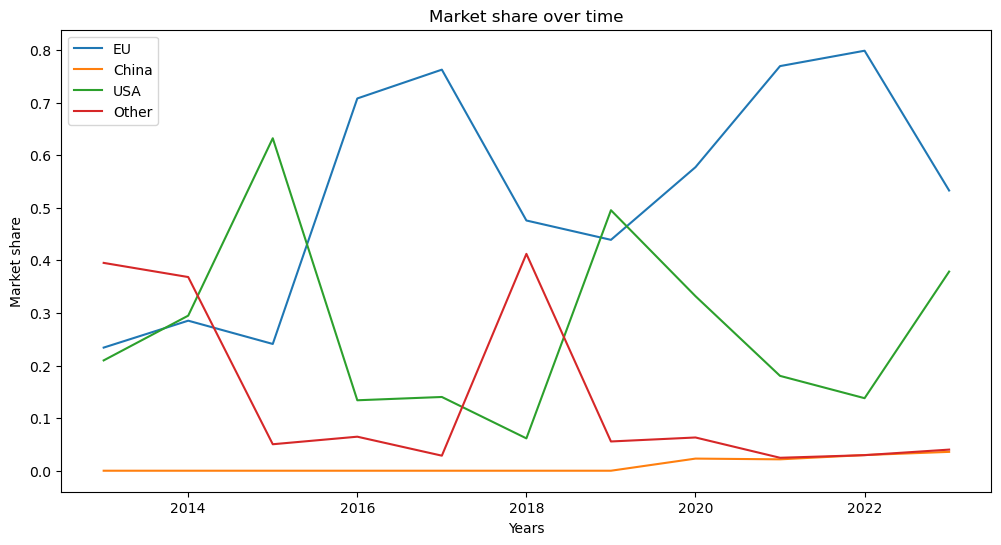

In [46]:
EU_share = []
China_share = []
USA_share = []
Other_share = []

for year in years:
    EU_year_df = df[(df['Europe'] == 1) & (df['year'] == year)] 
    if not EU_year_df.empty:  
        EU_share.append(EU_year_df['Market share'].sum())
print(EU_share)

for year in years:
    China_year_df = df[(df['China'] == 1) & (df['year'] == year)]  
    if not China_year_df.empty:  
        China_share.append(China_year_df['Market share'].sum())  

for year in years:
    USA_year_df = df[(df['USA'] == 1) & (df['year'] == year)]  
    if not USA_year_df.empty:  
        USA_share.append(USA_year_df['Market share'].sum()) 

for year in years:
    Other_year_df = df[(df['Other'] == 1) & (df['year'] == year)] 
    if not Other_year_df.empty:  
        Other_share.append(Other_year_df['Market share'].sum())

plt.figure(figsize=(12, 6))
plt.plot(years, EU_share)
plt.plot(years, China_share)
plt.plot(years, USA_share)
plt.plot(years, Other_share)
plt.legend(['EU', 'China', 'USA', 'Other'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('Market share over time')
plt.show()


## Estimering

In [13]:
N = df['ID'].unique().size
N
#print("market share value :", df['Market share'].size)
T = df['year'].unique().size
assert df.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {df.shape[0]}, {N*T}')

Data has N=112 and T=11 data is = 1232, 1232


In [15]:
y = df['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = df['Range'].values.reshape((N*T,1)) #1
Price = df['Price'].values.reshape((N*T,1)) #2
HP = df['HP'].values.reshape((N*T,1)) #3
ChargeTime = df['ChargeTime'].values.reshape((N*T,1))  #4
China = df['China'].values.reshape((N*T,1)) #5
X = np.hstack([ones, Range, Price, HP, ChargeTime, China])

print(f' y \n {y[:2]} \n ones: \n {ones[:2]} \n X: {X[:2]} \n {X.size} \n')

 y 
 [[0.]
 [0.]] 
 ones: 
 [[1.]
 [1.]] 
 X: [[1.00000000e+00 4.00000000e+02 3.30825789e+05 2.01000000e+02
  3.40000000e+01 1.00000000e+00]
 [1.00000000e+00 4.00000000e+02 3.30825789e+05 2.01000000e+02
  3.40000000e+01 1.00000000e+00]] 
 7392 



In [16]:
#OLS estimation
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     7.527
Date:                Tue, 06 Feb 2024   Prob (F-statistic):           5.68e-07
Time:                        17:52:49   Log-Likelihood:                 2164.3
No. Observations:                1232   AIC:                            -4317.
Df Residuals:                    1226   BIC:                            -4286.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0091      0.007     -1.298      0.1

In [17]:
clogit(y,X, cov_type='Ainv',theta0=None, deriv=0, quiet=False)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
def sim_data(N, J, theta) -> tuple:
    k = theta.size
    
    x = random.normal(size=(N, J, k)) + np.linspace(3,5,J).reshape(1,J, 1)
    v = utiliy(theta, x)
    e = genextreme.ppf(random.uniform(size=(N, J)), c=0)
    u = v + e # utility
    
    # Find which choice that maximizes utility.
    y = u.argmax(axis=1)
    
    label = ['y', 'x']
    d=dict(zip(label, [y, x]))
    return d

In [ ]:
J=5             # number of alternatives index j=0,..,J-1
N=10000         # number of observations
theta = np.array([1, -1, 2]).reshape(-1,1) #True parameters
print(theta) #Unknown for simalation and estimation
dta=sim_data(N, J, theta)
res=clogit(dta['y'], dta['x'], deriv=0)  # Estimate c-logit model

[[ 1]
 [-1]
 [ 2]]
Conditional logit
Initial log-likelihood -1.6094379124340998
Initial gradient
 [0.82316834 0.09811544 1.16469308]
Dep. var. : y 

parnames      theta_hat          se    t-values         jac
----------  -----------  ----------  ----------  ----------
var0            1.01316     0.01521    66.62309    -0.00000
var1           -1.00568     0.01810   -55.57030     0.00000
var2            1.98919     0.02688    74.00005     0.00000
# of observations : 10000
# log-likelihood. : -6676.024421896972 

Iteration info: 11 iterations, 48 evaluations of objective, and 12 evaluations of gradients
Elapsed time: 0.1492 seconds



/Users/mikkeldollerup/opt/anaconda3/lib/python3.9/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


In [ ]:
x = random.normal(size=(N, J, k)) + np.linspace(3,5,J).reshape(1,J, 1)
x

NameError: name 'k' is not defined